# Unsupervised machine learning techniques

Today we will continue working with the gene expression data of our mice, and try to find patterns in them with the help of unsupervised machine learning algorithms. Unsupervised methods are useful when we have so-called unlabeled data: samples with no group membership information, only their raw values.

Now our expression data isn't unlabeled: we know for every sample 1) what diet it had, 2) what strain it was. But we will not give that information to the upcoming ML methods. We will instead ask these methods to score / separate / cluster the samples based on their raw values only, and then we will verify whether they managed to do it in a way which is consistent with the labels that we had hidden from the algorithms.

The unsupervised techniques we will use today are principal component analysis (PCA), hierarchical clustering and K-means clustering, provided by the wonderful, feature-rich and easy-to-use `scikit-learn` package. Their website is worth taking a look for anyone interested in machine learning: it is not just a documentation, but also a great guide for a lot of techniques.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

## Load the expression data

We will need the original raw expression data, and your differential expression analysis csv. Adapt the below steps to make sure we are on the same page.

In [2]:
xls = pd.read_excel('files/S5.xlsx', header=2)

In [3]:
expr = xls.groupby('Gene.1').mean()  # or 'Gene' if you had used that for your DE calculations
expr = expr.loc[:, expr.columns.str.contains('Liver')]
is_hfd = pd.Series(expr.columns.str.contains('HFD'), index=expr.columns)  # diet labels for verification

Since `scikit-learn` likes to treat data as one sample per row, we should transpose our expression data matrix, such that rows stand for mice and columns stand for genes. Let's call the transposed form of `expr` as `data`.

In [4]:
data = expr.T
data.head()

Gene.1,544988,100043387,0610007C21Rik,0610007L01Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,mCG_21548,rp9
C57BL/6J_Liver_CD,6.183000,10.384,12.389,10.2875,8.116,12.281,8.364,9.440,7.033,10.904,...,9.104,8.152,10.427,9.668,9.903,10.175,6.939,9.885,7.335,9.943
DBA/2J_Liver_CD,6.353333,9.848,12.559,10.3900,8.422,12.305,8.257,8.576,7.126,10.949,...,9.087,7.754,10.162,9.411,9.565,10.361,7.398,9.945,7.801,9.795
BXD43_Liver_CD,6.262333,10.108,12.647,10.4110,8.235,11.949,8.578,8.264,7.374,11.024,...,9.330,7.616,10.062,9.576,9.650,10.231,7.447,10.123,7.789,9.860
BXD44_Liver_CD,6.263667,9.860,12.639,10.4195,8.135,11.895,8.539,8.815,7.325,10.665,...,9.058,7.292,10.233,9.685,9.721,10.146,7.552,9.319,7.708,9.715
BXD45_Liver_CD,6.270000,9.392,12.515,10.3060,8.198,12.160,8.298,9.418,7.526,10.669,...,8.847,7.756,10.173,9.603,9.687,10.261,7.600,9.510,7.703,9.772


## Task 1: principal component analysis
PCA takes a set of high-dimensional samples (vectors), and transforms them to a smaller set of variables using an orthogonal transformation. It finds a set of orthogonal vectors (their dimension identical to the dimension of your data points) and projects every sample to each of these orthogonal vectors with a simple dot product. The projections are called principal components, and they have some interesting properties that we will not go into detail just yet.

### 1.1 Initialize a PCA object with 4 components and transform your data.

In [5]:
#Do PCA with 4 components
pca = PCA(n_components=4)
pca_df = pca.fit_transform(data)


### 1.2 Plot the components against each other

Plotting the first component against the second is simple enough with matplotlib `scatter`, but you can do better and create a scatter plot for each pair using seaborn's `pairplot`. This requires your data to be a `DataFrame`, but you know how to turn a numpy matrix into a DF.

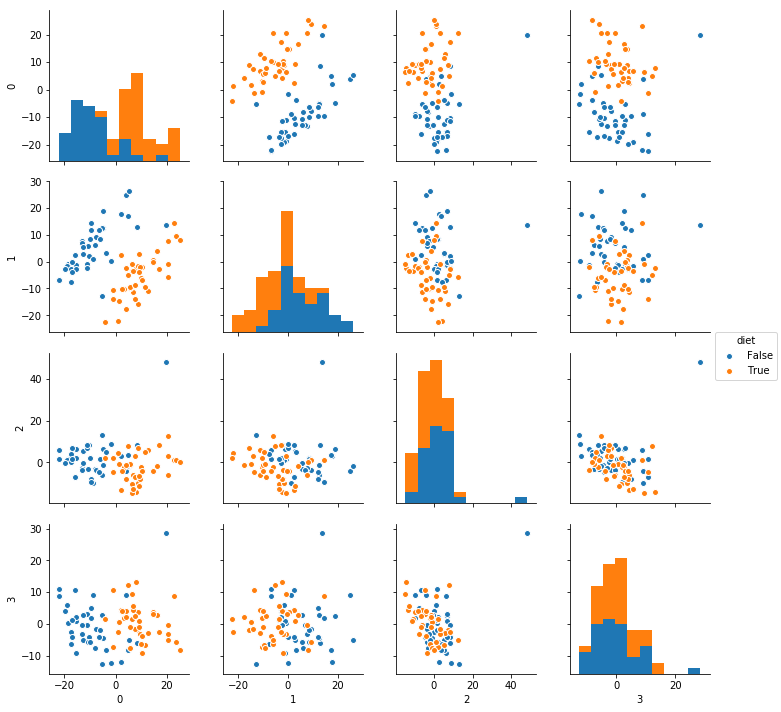

In [6]:
#Turn the pca data into a dataframe and add a column for the (diet) label

pca_data =  pd.DataFrame(pca_df, index = data.index)
pca_data['diet'] = is_hfd

pairplot = sns.pairplot(pca_data, vars = [0, 1,  2, 3, ] , hue='diet')

### 1.2.1 Add color information based on the diet
Are you impressed?

In [7]:
#Added already to the plot above

The upper pairplot shows the actual impressing power of unsupervised learning. The PCA succesfully identified the most important attribute for the seperation and divided the point cloud almost perfectly in the two categories. Like in the nature of PCA, especially for the first component the seperation is particularly clear.

### 1.2.2 Optional: is it enough to use every 200th gene and still get a nice PCA plot?

In [8]:
#Second pca with less data
pca_sparse = PCA(n_components=4)
pca_sparse_data = pca_sparse.fit_transform(data.iloc[:,::200])
pca_sparse_df =  pd.DataFrame(pca_sparse_data, index = data.index)
pca_sparse_df['diet'] = is_hfd

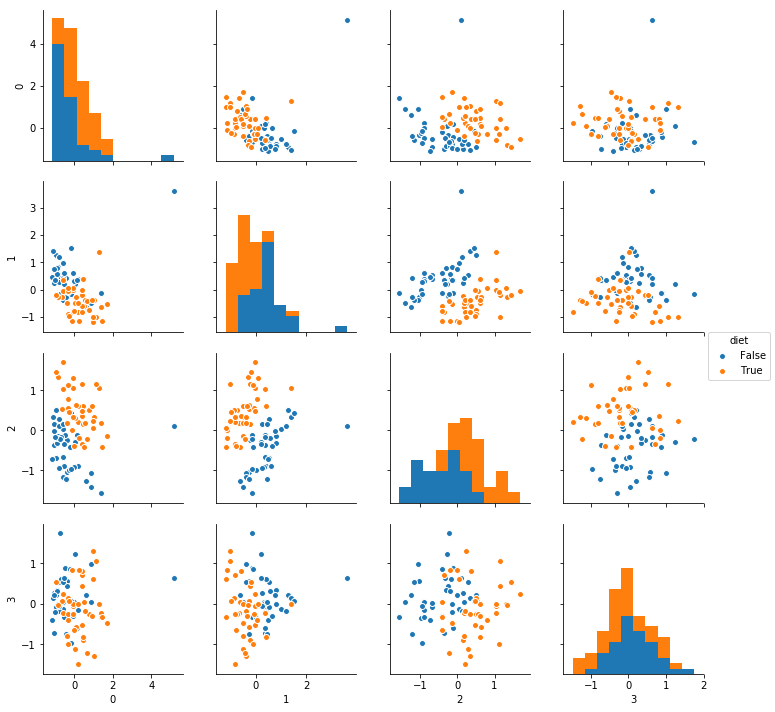

In [9]:
pairplot = sns.pairplot(pca_sparse_df, vars = [0, 1,  2, 3, ] , hue='diet')

As expected the quality gets a lot worse, but keeping in mind that we drastically reduced the dataset the PCA still produces results that are completly random. 

### 1.3 Find the component vectors that were used for the transformation. Are they orthogonal as promised? How would you verify it?

In [10]:
#Compute the dot product of each components with each transposed component

dot_product = np.dot(pca.components_, pca.components_.T)
dot_product

array([[ 1.00000000e+00, -1.62698089e-17, -7.15573434e-18,
         5.16757860e-17],
       [-1.62698089e-17,  1.00000000e+00,  3.78386558e-17,
         9.54097912e-18],
       [-7.15573434e-18,  3.78386558e-17,  1.00000000e+00,
        -3.52203076e-16],
       [ 5.16757860e-17,  9.54097912e-18, -3.52203076e-16,
         1.00000000e+00]])

We can also check how much of the variance is covered bei each principal component. The first component alone explains the impressive amount of almost 15% of the variance found in the dataset.

In [11]:
pca.explained_variance_ratio_

array([0.14460189, 0.09516149, 0.06550973, 0.04348441])

### 1.3.1 Optional: How correlated are the transformed values with each other? Why is it important?

In order to find the correlation in the transformes values we can use a heatmap. We expect that the vectors correlate perfect with itself, as usual, but also have no correlation to others. This is important, because would they correlate they would share some of the explained variance. By keeping them uncorrelated it is possible to cover more variance in total.

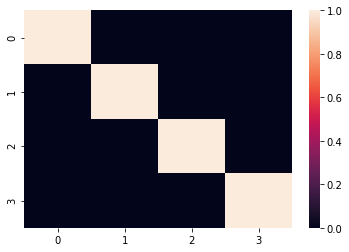

In [12]:
#Heatmap for correlation of the transformed data
hplot = sns.heatmap(dot_product)

### 1.4: Compare the first component vector's weights with the log-foldchange vector from your differential expression analysis. Visualize them on a scatter plot, and interpret what you see.
Remember, you computed the fold-change values by comparing expression values between CD and the HFD diets. PCA had no access to this information, and yet... Well, this is why it's such a popular data exploration technique.

You can also try a scatter plot for weight vs p-values, log10-p, etc. Some of them might look familiar.

In [13]:
#Load the differential expression data set
de_data = pd.read_csv('files/DEanalysis.csv', sep = '\t')
de_data = de_data.set_index("Gene.1")
de_data.head()

components = pca.components_

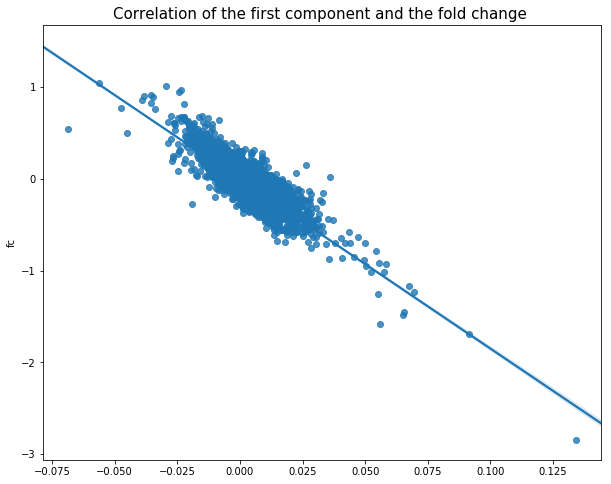

In [14]:
#Scatterplot of the first component and the fold change

fig, ax = plt.subplots(figsize=(10,8))
rplt = sns.regplot(x=components[0], y=de_data['fc'])
plt.title('Correlation of the first component and the fold change ', fontsize= 15)
plt.show()

There is a strong negative correlation between the first component and the foldchange of the two diets.

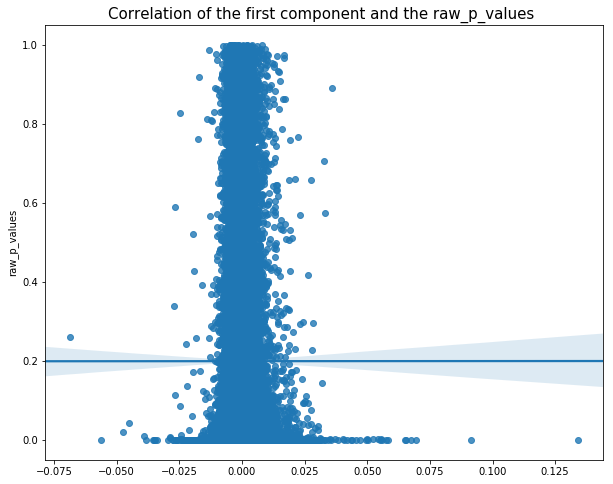

In [15]:
#Scatterplot of the first component and the raw p values

fig, ax = plt.subplots(figsize=(10,8))
rplt = sns.regplot(x=components[0], y=de_data['raw_p_values'])
plt.title('Correlation of the first component and the raw_p_values ', fontsize= 15)
plt.show()

For comparison, there is no correlation of the first component and the uncorrected p values of the expression data. 

### 1.5: Create a scatter plot for PC1 and PC2 only, but this time connect pairs of points that come from the same strain

This will involve `plt.scatter`, and a `for` loop with `plt.plot` calls.
The pattern of the resulting lines might be quite interesting. If it is, try to explain why.

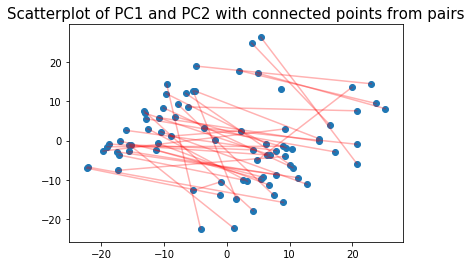

In [16]:
indexes = pca_data.index.tolist()

#Iterate through strain names and only look only at the strain name, which is stored in split[0]
for sample_id, count in Counter([x.split("_")[0] for x in indexes]).items():
    
    #Check if mouse strain name is existent with CD and HFD tag ( count == 2)
    if count == 2:
        
        #Complete the name
        s1 = sample_id + "_Liver_CD"
        s2 = sample_id + "_Liver_HFD"
        
        #Combine those corresponding dots with a line
        plt.plot([pca_data.loc[s1,0], pca_data.loc[s2,0]], [pca_data.loc[s1,1], pca_data.loc[s2,1]], color='r', alpha=0.3)


plt.title('Scatterplot of PC1 and PC2 with connected points from pairs', fontsize= 15)
plt.scatter(pca_data[0], pca_data[1])
plt.show()

## Task 2: Hierarchical clustering

You had created a cluster-map before (Day 2) and remember those dendrograms on the top and left edges of the figure. They are a result of an unsupervised technique called hierarchical clustering. It iteratively merges single data points into bigger and bigger clusters based on their similarity, one at a time, until all points belong to one big cluster. Seaborn's `clustermap` does it on both axes by default, and produces a heatmap of the values as well.

### 2.1 Create a clustermap
From your first PCA component vector, take the genes with the 15 largest positive, and 15 largest negative weights, and create a smaller expression matrix with these 30 genes only. Use seaborn's `clustermap` to do a hierarchical clustering of genes and mice alike, as well as a heatmap.


### 2.2 Display the diet at the bottom of the mice's dendrogram
You will have to convert `is_hfd`'s values to color values first: `y` or `yellow` for 0 and `b` or `blue` for 1 should do fine.

In [17]:
#Merge genenames into the pca component table
compo_frame = pd.DataFrame.from_records(components.T, columns=['1', '2', '3','4'], index=data.columns)

#Search for the 15 genes with the largest positive and the 15 genes with smallest weights and save their names in a new list
largest = compo_frame.nlargest(15, '1')
smallest = compo_frame.nsmallest(15, '1')
interesting_30 = largest.index.tolist() + smallest.index.tolist()

interesting_30

['Cyp2b9',
 'Lcn2',
 'Cidea',
 'Saa2',
 'AB056442',
 'Cyp2b13',
 'Lgals1',
 'Cd36',
 'D630002G06Rik',
 'Saa1',
 '9030619P08Rik',
 'Orm2',
 'Cyp2a22',
 'Orm3',
 'Ly6d',
 'Hsd3b5',
 'Serpina4-ps1',
 'Moxd1',
 'Slco1a1',
 'Hamp',
 'Srgap3',
 'Agxt2l1',
 'Gpr110',
 'Csad',
 'Ces6',
 'V165-D-J-Cmu',
 'Cyp4a12b',
 'Gm15441',
 'Grm8',
 'Meg3']

In [18]:
#Filter the Gene-Strain tabel after those genes to get the other data
data_30genes = data.loc[:, interesting_30]

data_30genes.head()

Gene.1,Cyp2b9,Lcn2,Cidea,Saa2,AB056442,Cyp2b13,Lgals1,Cd36,D630002G06Rik,Saa1,...,Srgap3,Agxt2l1,Gpr110,Csad,Ces6,V165-D-J-Cmu,Cyp4a12b,Gm15441,Grm8,Meg3
C57BL/6J_Liver_CD,6.908,13.766,6.495,14.087,5.579,5.299,11.024,10.116,6.502,12.354,...,8.2065,11.288,9.841,11.565,11.429,6.794,13.275,6.749,7.790,8.172
DBA/2J_Liver_CD,6.637,8.521,6.405,8.531,6.368,5.460,9.575,9.549,6.806,7.294,...,8.4410,11.388,9.165,11.799,11.179,6.729,13.948,7.144,7.328,9.242
BXD43_Liver_CD,6.672,9.705,6.507,9.270,5.646,5.133,9.416,10.135,6.352,7.435,...,7.8515,12.873,9.222,11.185,10.797,6.616,13.982,10.665,7.512,8.517
BXD44_Liver_CD,14.212,13.155,9.253,12.872,8.180,7.184,12.808,12.681,7.431,10.699,...,7.7255,11.077,7.185,10.648,9.746,6.541,13.262,7.279,6.848,8.354
BXD45_Liver_CD,6.978,8.280,6.396,8.233,6.082,5.223,9.668,9.063,6.764,6.445,...,8.5050,12.132,9.710,11.731,11.054,6.906,13.848,6.673,7.696,10.138


In [19]:
#Add is_hfd column to get a categorical column for coloring
data_30genes['is_hfd'] = is_hfd

#Replace labels with color labels
data_30genes['is_hfd'] = data_30genes['is_hfd'].replace(True, "b")
data_30genes['is_hfd'] = data_30genes['is_hfd'].replace(False, "y")

data_30genes.head()

Gene.1,Cyp2b9,Lcn2,Cidea,Saa2,AB056442,Cyp2b13,Lgals1,Cd36,D630002G06Rik,Saa1,...,Agxt2l1,Gpr110,Csad,Ces6,V165-D-J-Cmu,Cyp4a12b,Gm15441,Grm8,Meg3,is_hfd
C57BL/6J_Liver_CD,6.908,13.766,6.495,14.087,5.579,5.299,11.024,10.116,6.502,12.354,...,11.288,9.841,11.565,11.429,6.794,13.275,6.749,7.790,8.172,y
DBA/2J_Liver_CD,6.637,8.521,6.405,8.531,6.368,5.460,9.575,9.549,6.806,7.294,...,11.388,9.165,11.799,11.179,6.729,13.948,7.144,7.328,9.242,y
BXD43_Liver_CD,6.672,9.705,6.507,9.270,5.646,5.133,9.416,10.135,6.352,7.435,...,12.873,9.222,11.185,10.797,6.616,13.982,10.665,7.512,8.517,y
BXD44_Liver_CD,14.212,13.155,9.253,12.872,8.180,7.184,12.808,12.681,7.431,10.699,...,11.077,7.185,10.648,9.746,6.541,13.262,7.279,6.848,8.354,y
BXD45_Liver_CD,6.978,8.280,6.396,8.233,6.082,5.223,9.668,9.063,6.764,6.445,...,12.132,9.710,11.731,11.054,6.906,13.848,6.673,7.696,10.138,y


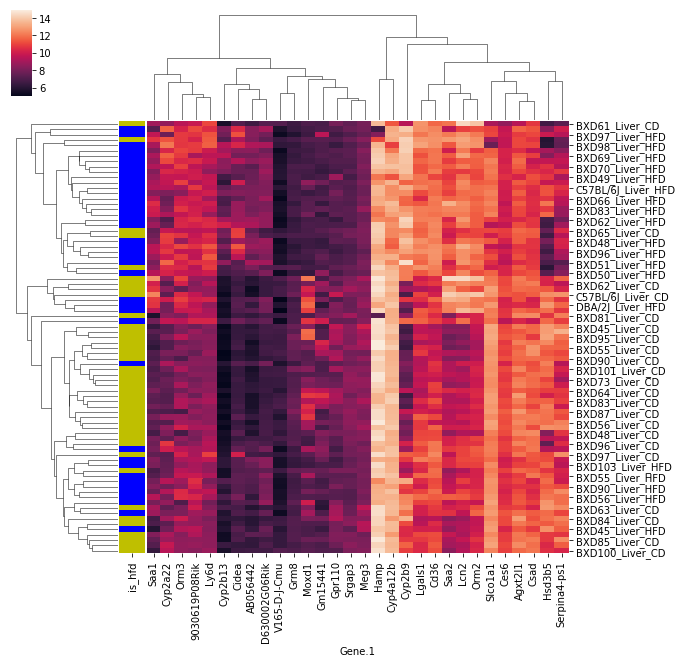

In [20]:
cmap = sns.clustermap(data_30genes.iloc[:,:-1], row_colors= data_30genes['is_hfd'])


In the generated clustermap the clustering of CD and HFD entrys is supoptimal. Apart from two big blocks, the right and the left side, its rather unsorted. What we still can see is the seperation of the genese which are down and up regulated in each mouse strain.

### 2.3 Standardize the matrix
It is hard to see the fine differences between the gene expression levels acros mice, because the range of general expression levels across genes is much higher. To circumvent this, we usually standardize our data: for every gene, subtract the mean and divide by the standard deviation.

You can do this with a pandas one-liner, or use sklearn's `StandardScaler` tool. You can simply extend the above cell with this.

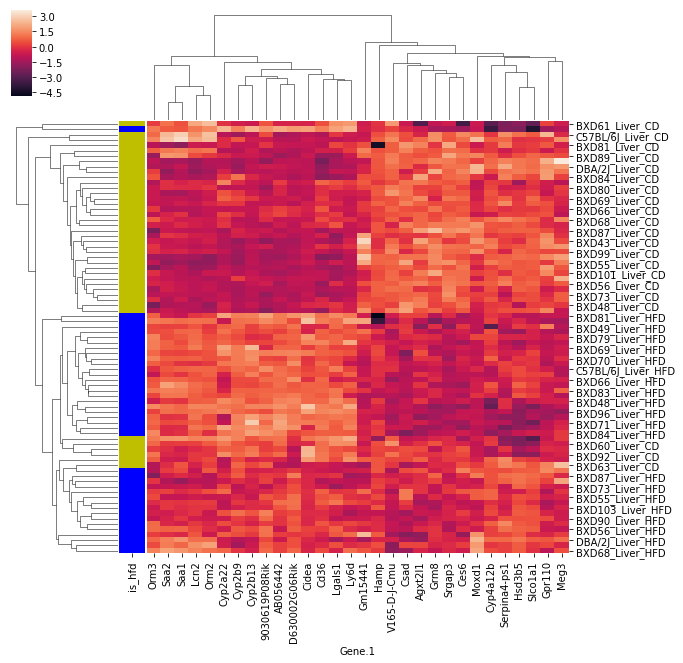

In [21]:
#Standardize the data in old fashion way, but ignore the 'is_hfd' column, since it's categorical. 
#We have to add it later manually again
data_30_standardized = (data_30genes.iloc[:,:-1] - data_30genes.iloc[:,:-1].mean())/data_30genes.iloc[:,:-1].std()

data_30_standardized['is_hfd'] = is_hfd
data_30_standardized['is_hfd'] = data_30_standardized['is_hfd'].replace(True, "b")
data_30_standardized['is_hfd'] = data_30_standardized['is_hfd'].replace(False, "y")
data_30_standardized

cmap = sns.clustermap(data_30_standardized.iloc[:,:-1], row_colors= data_30genes['is_hfd'])

### 2.4 Try different linkage methods
The linkage method defines how cluster similarities are defined. For example, `single` defines the distance of two clusters as the smallest distance of any two elements between them. Its opposite is `complete` which takes the largest distance of any two elements across two clusters. Middle grounds are `centroid`, `average`, and a few more. Look at how they affect the topology of the clusters. Which one seems most suitable in our case?

The default method for the clustermap is "single" and we will also try out the two methods 'weighted' and 'ward', which uses the Ward variance minimization algorithm.  
Acutally, there is just little difference if you use the standarized data between the difference linkage methods.

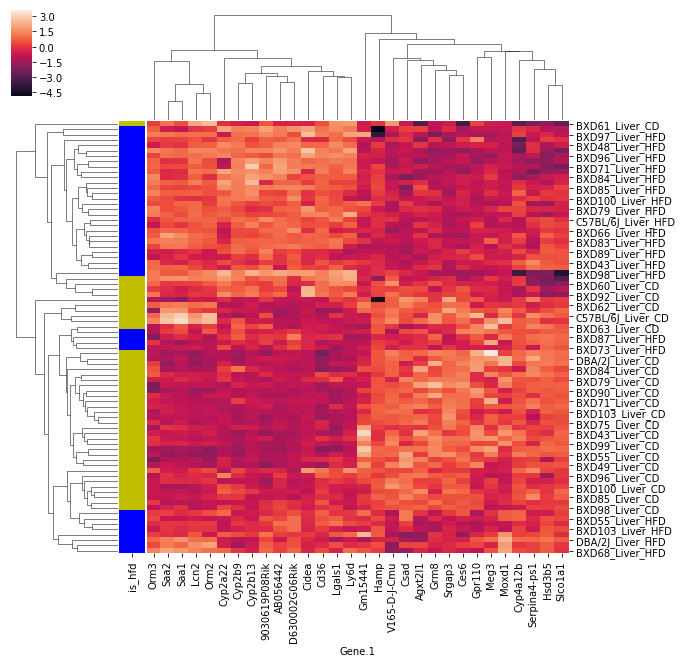

In [22]:
cmap = sns.clustermap(data_30_standardized.iloc[:,:-1], row_colors= data_30genes['is_hfd'], method="weighted")

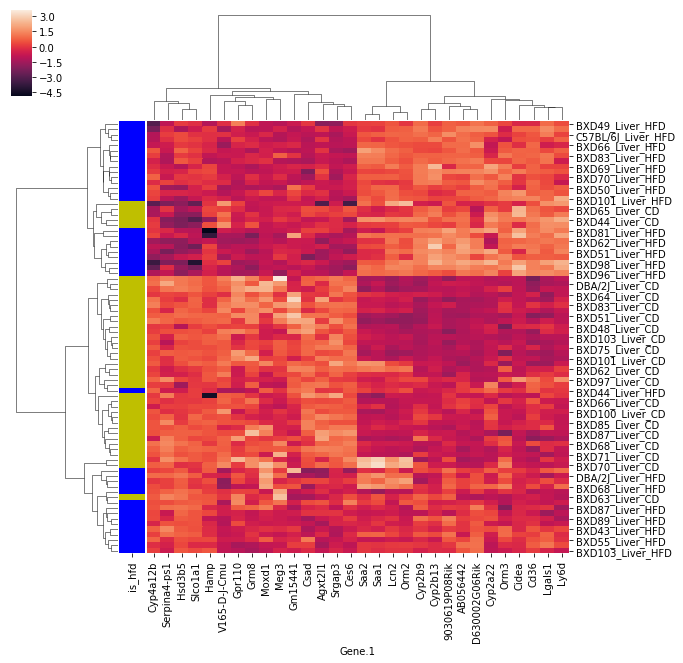

In [23]:
sns.clustermap(data_30_standardized.iloc[:,:-1], row_colors= data_30genes['is_hfd'], method="ward")

## Task 3: K-means clustering

K-means clustering attempts to create `k` virtual samples, whose average distance to the nearest actual samples is as small as possible. These `k` virtual samples are called cluster centers/prototypes or centroids. Each sample is assigned to the nearest centroid, therefore partitioning the samples to k clusters.

### 3.1 Perform k-means clustering on the expression dataset. What k should you choose?

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(data)

In [25]:
#The input data labeled with the according cluster
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [26]:
#The two cluster center
kmeans.cluster_centers_

array([[ 6.29646667, 10.06415   , 12.6028    , ...,  9.796275  ,
         7.699625  ,  9.78115   ],
       [ 6.33614634, 10.16673171, 12.61097561, ...,  9.88882927,
         7.72009756,  9.70326829]])

I think k = 2 is reasonable choice since we ware expecting one cluster for the HFD data and one for the CD data.

### 3.2 Compare the resulting clusters with the diet labels

The comparing can be done by comparing the 'is_hfd' column entry with the assigned cluster. This task can be performed by either using our eyes since the human brain is incredibly and unbeatable good at pattern recognition; or by an cross table. 

In [27]:
kmeans_res = pd.DataFrame(kmeans.labels_, index=is_hfd.index)

results_kmeans = pd.concat([is_hfd, kmeans_res], axis=1)
results_kmeans.columns = ['is_hfd', 'cluster']
results_kmeans

#HFD == False strains should be in cluster 1, and HFD == True mice should be in cluster 0.

,is_hfd,cluster
C57BL/6J_Liver_CD,False,0
DBA/2J_Liver_CD,False,0
BXD43_Liver_CD,False,0
BXD44_Liver_CD,False,0
BXD45_Liver_CD,False,0
BXD48_Liver_CD,False,0
BXD49_Liver_CD,False,0
BXD51_Liver_CD,False,0
BXD55_Liver_CD,False,0
BXD56_Liver_CD,False,0


If we compare the resulting cluster assignment with two clusters with the diet labels, it is easy to see that the kmeans algorithm separates the mice strains accordingly to the diet. There are only a few examples where this assignment is not correct.

In [28]:
count_table = pd.crosstab(results_kmeans.iloc[:,0]==True, results_kmeans.iloc[:,1]==1)
count_table

cluster,False,True
is_hfd,,
False,40,1
True,0,40


Using a crosstable the results get even clearer. Only two datapoints were not assigned the "right" diet cluster. Maybe if the kmeans algorithm is rerun the results will be slighty different.

### 3.3 Optional: with k=2, take the centroids, and transform them with the same PCA that you had trained earlier. Mark them on the PC1 vs PC2 plot.

In [29]:
#I already used k = 2, so we can use the previous pca here

pca_kmeans = pca.fit_transform(kmeans.cluster_centers_)
pca_kmeans_data =  pd.DataFrame(pca_kmeans, index = None)
pca_kmeans_data

,0,1
0,11.151816,7.331535e-14
1,-11.151816,7.331535e-14


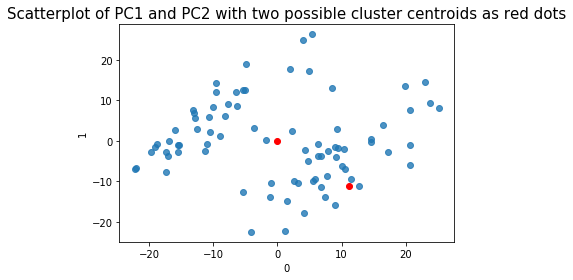

In [30]:
#Plot the two centroids as red dots in the PCA1/PCA2 regression-plot

plt.title('Scatterplot of PC1 and PC2 with two possible cluster centroids as red dots', fontsize= 15)

rplot = sns.regplot(x = pca_data[0], y = pca_data[1], fit_reg = False)
#The cluster points
plt.scatter(pca_kmeans_data[0][0], pca_kmeans_data[0][1], color="red");
plt.scatter(pca_kmeans_data[1][0], pca_kmeans_data[1][1], color="red");

It is fun to see that everytime the clusters are computed they are located at slighty different positions. Sometimes one can seem a little bit off, but still it is clearly visible that there is one centroid for the HFD and one for the CD data.

### 3.4 Train a 2-means clustering on every second sample and predict on the other half of the samples
Since our CD and HFD samples come in two big batches, you can just use `::2` and `1::2` to split them. What do you find?

In [31]:
trainingdata = data[::2]
testdata = data[1::2]

#Learn on first half
kmeans_task2 = KMeans(n_clusters=2).fit(trainingdata)
kmeans_task2.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [32]:
#Predict on second
kmeans_task2.predict(testdata)

#Since train and test dataset are basically identical the result of the prediction should also 
#be the same as the one of the training


array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

What we find is further proove for the mighty power of kmeans. 
Since we split the data evenly by two, in each, the training and the test data, the first half should be cluster 0, the second half cluster 1.